In [1]:
import timm
print(timm.__version__)
print("resnet50" in timm.list_models())

1.0.22
True


In [2]:
import os 
import numpy as np 
from PIL import Image 
import albumentations as A 
import torch

In [3]:
root = 'data/train'
labels_path = os.path.join(root,'labels')
images_path = os.path.join(root,'images')

In [4]:
label_files = os.listdir(labels_path)
label_files = [f for f in label_files if f.endswith('.txt')]
label_files[:4]

['Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.txt',
 'J2_jpg.rf.454825a65d0eafdc0586a7ff687848a4.txt',
 'M4_jpg.rf.2e4ce0d9adf16aa3d33a2ba77e567416.txt',
 'T23_jpg.rf.c8c9b394fc0b451c31f76bd56357a6d0.txt']

### In the original data.py file we have used the 'split' because we have only One dot but in my custom data I have multiple dots so to get the correct text file we have to split it from the back i.e. performe a right split 'rsplit' and taking the first part that's how we get our image base name

In [5]:
idx = 0 
label_file = label_files[idx]
image_file = label_file.rsplit('.',1)[0] + '.jpg'

label_path,image_path = os.path.join(labels_path,label_file),os.path.join(images_path,image_file)
label_path,image_path

('data/train/labels/Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.txt',
 'data/train/images/Z28_jpg.rf.d7e9d8c8e6556a0c10671a931a92ff58.jpg')

In [6]:
img = Image.open(image_path)
img_np = np.array(img)
print(img_np.shape)

(640, 480, 3)


In [7]:
annotations = open(label_path).read().strip().split(' ')
annotations

['25', '0.31875', '0.6703125', '0.3541666666666667', '0.25625']

In [8]:
annotations = open(label_path).read().strip().split('\n')
class_labels = []
bounding_boxes = []

for annotation in annotations:
    ann = annotation.split(" ")
    class_labels.append(int(ann[0]))
    bounding_boxes.append([float(x) for x in ann[1:]])

class_labels, bounding_boxes = np.array(class_labels,dtype=int), np.array(bounding_boxes,dtype=float)
class_labels, bounding_boxes

(array([25]), array([[0.31875   , 0.6703125 , 0.35416667, 0.25625   ]]))

In [9]:
transfrom = A.Compose(
    [
        A.Resize(500,500),
        A.RandomCrop(224,224,p=0.33),
        A.Resize(224,224),
        A.HorizontalFlip(p=0.6),
        A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.pytorch.transforms.ToTensorV2()   
    ],
    bbox_params=A.BboxParams(format='yolo',label_fields=['class_labels'])
)

aug = transfrom(image= img_np,bboxes = bounding_boxes,class_labels = class_labels)
aug.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [10]:
aug_img = aug['image']
aug_boxes = aug['bboxes']
aug_labels = aug['class_labels']
print(aug_img.shape)
print(aug_boxes)
print(aug_labels)


torch.Size([3, 224, 224])
[[0.64918155 0.59891188 0.70163691 0.57198666]]
[25]


In [11]:
aug_tensor = aug_img 
labels_tensor = torch.tensor(aug_labels,dtype=torch.long)
boxes_tensor = torch.tensor(aug_boxes,dtype=torch.float32)
# aug_tensor,labels_tensor,boxes_tensor
labels_tensor,boxes_tensor

(tensor([25]), tensor([[0.6492, 0.5989, 0.7016, 0.5720]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..1.0888017].


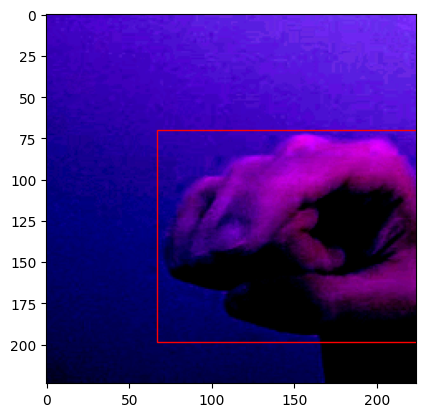

In [12]:
import matplotlib.pyplot as plt 
from src.utils.boxes import rescale_bboxes 

plt.imshow(aug_tensor.permute(1,2,0))
abs_boxes = rescale_bboxes(boxes_tensor,(224,224))

for box in abs_boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(
        plt.Rectangle((xmin,ymin), xmax-xmin,ymax-ymin,fill = False, color ='red',linewidth = 1)
    )

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..1.0888017].


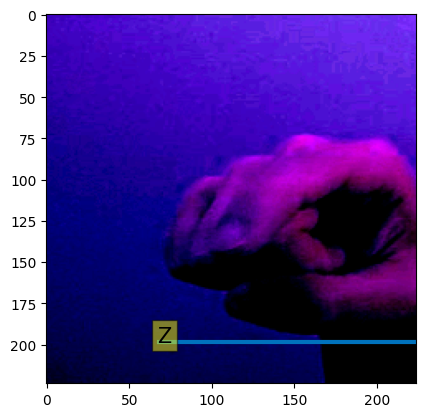

In [13]:
import matplotlib.pyplot as plt 
from src.utils.boxes import rescale_bboxes 
from src.utils.setup import get_classes

plt.imshow(aug_tensor.permute(1,2,0))
ax = plt.gca()
CLASSES = get_classes()

abs_boxes = rescale_bboxes(boxes_tensor,(224,224))

for label,box in zip(labels_tensor,abs_boxes):
    xmin, ymin, xmax, ymin = box 
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,fill= False,color=(0.000, 0.447, 0.741),linewidth = 3))
    ax.text(xmin, ymin, f'{CLASSES[label]}', fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))

plt.show()

In [14]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from colorama import Fore

from src.utils.boxes import rescale_bboxes, stacker
from src.utils.setup import get_classes
from src.utils.logger import get_logger
from src.utils.rich_handlers import DataLoaderHandler


class DETRData(Dataset):
    def __init__(self, path, train=True):
        super().__init__()
        self.path = path
        self.labels_path = os.path.join(self.path, 'labels')
        self.images_path = os.path.join(self.path, 'images')
        self.label_files = os.listdir(self.labels_path)
        self.labels = [f for f in self.label_files if f.endswith('.txt')]
        self.train = train

        # Initialize logger
        self.logger = get_logger("data_loader")
        self.data_handler = DataLoaderHandler()

        dataset_info = {
            "Dataset Path": self.path,
            "Mode": "Training" if train else "Testing",
            "Total Samples": len(self.labels),
            "Images Path": self.images_path,
            "Labels Path": self.labels_path
        }
        self.data_handler.log_dataset_stats(dataset_info)

        transform_list = [
            "Resize to 500x500",
            "Random Crop 224x224 (training only)",
            "Final Resize to 224x224",
            "Horizontal Flip p=0.5 (training only)",
            "Color Jitter (training only)",
            "Normalize (ImageNet stats)",
            "Convert to Tensor"
        ]
        self.data_handler.log_transform_info(transform_list)

    def safe_transform(self, image, bboxes, labels, max_attempts=50):
        self.transform = A.Compose(
            [
                A.Resize(500, 500),
                *([A.RandomCrop(width=224, height=224, p=0.33)] if self.train else []),
                A.Resize(224, 224),
                *([A.HorizontalFlip(p=0.5)] if self.train else []),
                *([A.ColorJitter(brightness=0.3, contrast=0.3,
                                 saturation=0.3, hue=0.3, p=0.5)] if self.train else []),
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ],
            bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
        )

        for attempt in range(max_attempts):
            try:
                transformed = self.transform(
                    image=image,
                    bboxes=bboxes,
                    class_labels=labels
                )
                if len(transformed['bboxes']) > 0:
                    return transformed
            except:
                continue

        return {
            'image': image,
            'bboxes': bboxes,
            'class_labels': labels
        }

    def __len__(self):
        return len(self.labels)

# idx = 0 
# label_file = label_files[idx]
# image_file = label_file.rsplit('.',1)[0] + '.jpg'

# label_path,image_path = os.path.join(labels_path,label_file),os.path.join(images_path,image_file)
# label_path,image_path

    def __getitem__(self, idx):
        label_path = os.path.join(self.labels_path, self.labels[idx])
        image_name = self.labels[idx].rsplit('.',1)[0]
        image_path = os.path.join(self.images_path, f'{image_name}.jpg')

        img = Image.open(image_path)
        with open(label_path, 'r') as f:
            annotations = f.readlines()

        class_labels = []
        bounding_boxes = []
        for annotation in annotations:
            ann = annotation.strip().split(' ')
            class_labels.append(int(ann[0]))
            bounding_boxes.append([float(x) for x in ann[1:]])

        bounding_boxes = np.array(bounding_boxes)
        class_labels = np.array(class_labels)

        augmented = self.safe_transform(
            image=np.array(img),
            bboxes=bounding_boxes,
            labels=class_labels
        )

        aug_img_tensor = augmented['image']
        aug_boxes = torch.tensor(augmented['bboxes'], dtype=torch.float32)
        aug_labels = torch.tensor(augmented['class_labels'], dtype=torch.long)

        return aug_img_tensor, {"labels": aug_labels, "boxes": aug_boxes}

In [15]:
dataset = DETRData("data/train", train=True)
dataloader = DataLoader(dataset, collate_fn=stacker, batch_size=4, drop_last=True)

X, y = next(iter(dataloader))
print(Fore.LIGHTCYAN_EX + str(y) + Fore.RESET)

CLASSES = get_classes()


        📊 Dataset Statistics        
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Metric        ┃ Value             ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Dataset Path  │ data/train        │
│ Mode          │ Training          │
│ Total Samples │ 996               │
│ Images Path   │ data/train/images │
│ Labels Path   │ data/train/labels │
└───────────────┴───────────────────┘

╭────────────────────────────────────────────── 🔄 Data Transforms ───────────────────────────────────────────────╮
│ • Resize to 500x500                                                                                             │
│ • Random Crop 224x224 (training only)                                                                           │
│ • Final Resize to 224x224                                                                                       │
│ • Horizontal Flip p=0.5 (training only)                                                                         │
│ • Color Jitter (training only)                                                                                  │
│ • Normalize (ImageNet stats)                                                                                    │
│ • Convert to Tensor                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[{'labels': tensor([25]), 'boxes': tensor([[0.6812, 0.6703, 0.3542, 0.2563]])}, {'labels': tensor([9]), 'boxes': tensor([[0.4670, 0.5344, 0.9340, 0.9312]])}, {'labels': tensor([12]), 'boxes': tensor([[0.4203, 0.6681, 0.8407, 0.6638]])}, {'labels': tensor([19]), 'boxes': tensor([[0.4176, 0.7640, 0.8351, 0.4721]])}]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6324171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831932..1.8382571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4285712].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.2489083].


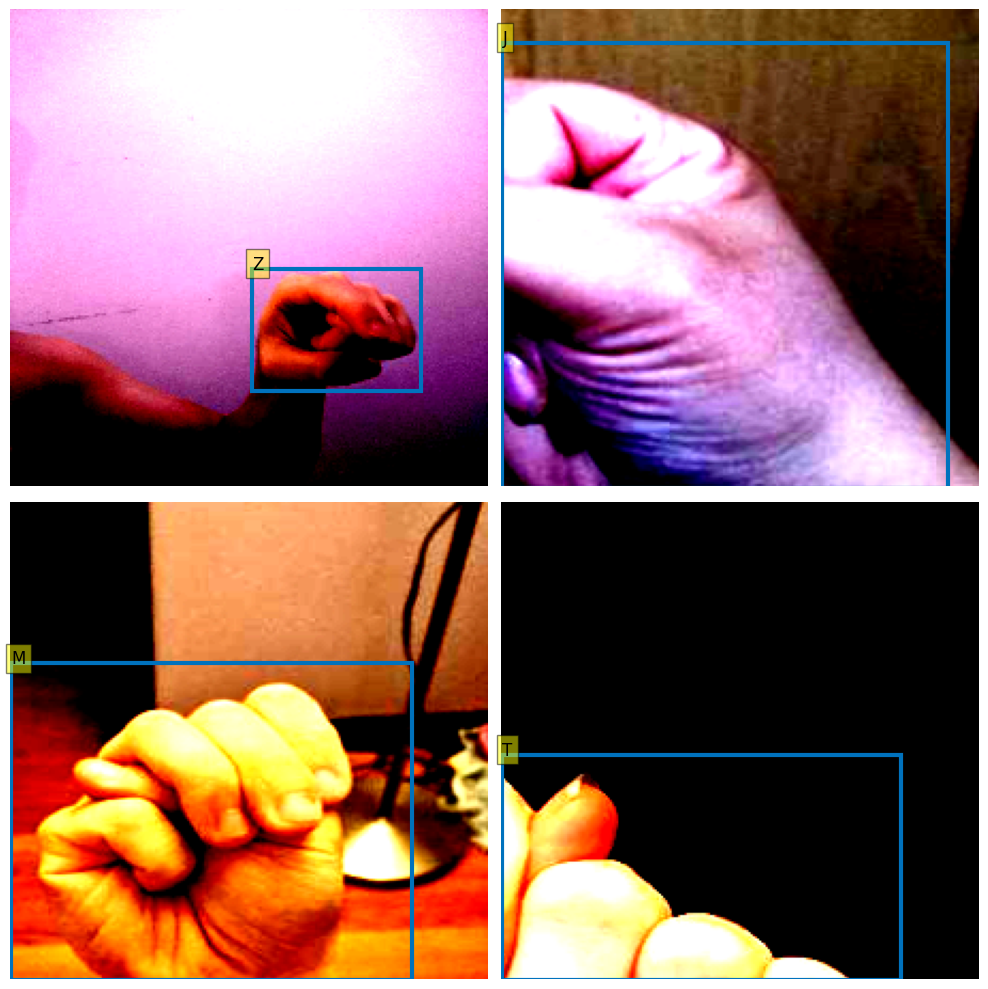

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = ax.flatten()

for idx, (img, annotations, ax) in enumerate(zip(X, y, axs)):
    ax.imshow(img.permute(1, 2, 0))

    boxes = rescale_bboxes(annotations['boxes'], (224, 224))
    box_classes = annotations['labels']

    for cls, box in zip(box_classes, boxes):
        xmin, ymin, xmax, ymax = box.numpy()
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=(0, 0.447, 0.741), linewidth=3
        ))

        ax.text(xmin, ymin, CLASSES[cls], fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5))

    ax.axis("off")

plt.tight_layout()
plt.show()


In [17]:
root = 'data/train'
labels_path = os.path.join(root,'labels')
images_path = os.path.join(root,'images')

label_files = os.listdir(labels_path)
label_files = [f for f in label_files if f.endswith('.txt')]
label_file = label_files[4]
print(label_file)
image_file = label_file.rsplit('.',1)[0] + '.jpg' 
image_file

L23_jpg.rf.9871c514a88ee4257f04476802731971.txt


'L23_jpg.rf.9871c514a88ee4257f04476802731971.jpg'

In [18]:
root = 'data/train'
labels_path = os.path.join(root,'labels')
images_path = os.path.join(root,'images')

label_files = os.listdir(labels_path)
label_files = [f for f in label_files if f.endswith('.txt')]

idx = 4
label_file = label_files[idx]
image_file = label_file.rsplit('.',1)[0] + '.jpg' 

label_path, image_path = os.path.join(labels_path, label_file), os.path.join(images_path,image_file)
label_path,image_path

transform = A.Compose([
    A.Resize(500, 500),
    A.RandomCrop(224, 224, p=0.33),
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    A.ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

img = Image.open(image_path)

annotations = open(label_path).read().strip().split('\n')
class_label = []
bounding_boxes = []

for ann in annotations:
    ann = ann.split(' ')
    class_label.append(int(ann[0]))
    bounding_boxes.append([float(x) for x in ann[1:]])

class_label, bounding_boxes = np.array(class_label,dtype=int), np.array(bounding_boxes,dtype=float)

def safe_transform(transform,image,bboxes,labels,max_attempts=10):
    for i in range(max_attempts):
        try:
            out = transform(image=image,bboxes=bboxes,class_labels=labels)
            fig,ax = plt.subplots(figsize=(4,4))
            ax.imshow(out['image'].permute(1,2,0))
            abs_boxes = rescale_bboxes(torch.tensor(out['bboxes']),(224,224))

            for box in abs_boxes:
                xmin, ymin, xmax, ymax = box
                ax.add_patch(
                    plt.Rectangle(
                        (xmin,ymin),
                        xmax-xmin,
                        ymax-ymin,
                        fill= False,
                        color = 'red',
                        linewidth = 2                   
                    )
                )
            
            ax.set_title(f"attempts {i+1} - Boxes: {len(out['bboxes'])}")
            ax.axis('off')
            plt.show()

            if len(out['bboxes'])>0:
                print(f"Accepted on attempt {i+1}")
                return out 
            
        except Exception as e:
            print(f'error at attempt {i+1}: {e}')
    
    print("All attempts failed — returning original image.")
    return {"image": image, "bboxes": bboxes, "class_labels": labels}



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.448279].


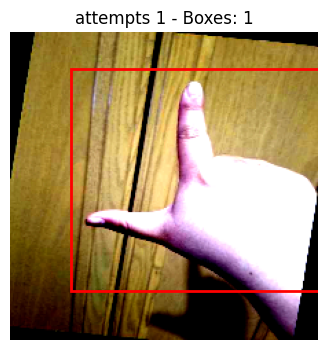

Accepted on attempt 1


In [19]:
out = safe_transform(
    transform=transform,
    image=np.array(img),
    bboxes=bounding_boxes,
    labels=class_label
)


In [ ]:
# Cell 1: Imports and Setup
from data import DETRData
from model import DETR 
import torch 
from torch import load 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt 
from utils.boxes import rescale_bboxes 
from utils.setup import get_classes 
from utils.logger import get_logger 
from utils.rich_handlers import TestHandler, DetectionHandler
from torchvision.ops import nms, box_convert
import time

# ============================================================
# Cell 2: Initialize Logger and Handlers
logger = get_logger('test')
test_handler = TestHandler()
detection_handler = DetectionHandler()
logger.print_banner()

# ============================================================
# Cell 3: Set Detection Parameters
CONFIDENCE_THRESHOLD = 0.5  # Only keep predictions with confidence > 0.5
NMS_THRESHOLD = 0.5         # IoU threshold for NMS
num_classes = 26

print(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}")
print(f"NMS Threshold: {NMS_THRESHOLD}")
print(f"Number of Classes: {num_classes}")

# ============================================================
# Cell 4: Load Dataset and Model
test_dataset = DETRData('data/test', train=False)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1, drop_last=False)  # batch_size=1 for single image

model = DETR(num_classes=num_classes)
model.eval() 
model.load_pretrained('checkpoints/100_model.pt')

print(f"Dataset size: {len(test_dataset)}")
print(f"Model loaded successfully")

# ============================================================
# Cell 5: Load a Single Image
x, y = next(iter(test_dataloader))

print(f"Image shape: {x.shape}")  # Should be [1, 3, 224, 224]
print(f"Image tensor - Min: {x.min():.3f}, Max: {x.max():.3f}")

# Visualize the input image
plt.figure(figsize=(6, 6))
plt.imshow(x[0].permute(1, 2, 0))
plt.title("Input Image")
plt.axis('off')
plt.show()

# ============================================================
# Cell 6: Run Model Inference
logger.test('running inference on test batch')

start_time = time.time()
result = model(x)
inference_time = (time.time() - start_time) * 1000  # convert to ms

print(f"Inference time: {inference_time:.2f} ms")
print(f"Result keys: {result.keys()}")
print(f"Predicted logits shape: {result['pred_logits'].shape}")
print(f"Predicted boxes shape: {result['pred_boxes'].shape}")

# ============================================================
# Cell 7: Extract Predictions (Softmax and Get Max Class)
probabilities = result['pred_logits'].softmax(-1)[:, :, :-1]  # Exclude background class
max_probs, max_classes = probabilities.max(-1)

print(f"Probabilities shape: {probabilities.shape}")
print(f"Max probabilities shape: {max_probs.shape}")
print(f"Max classes shape: {max_classes.shape}")
print(f"\nTop 5 predictions (before filtering):")
top5_probs, top5_indices = max_probs[0].topk(5)
for i, (prob, idx) in enumerate(zip(top5_probs, top5_indices)):
    print(f"  {i+1}. Class: {max_classes[0, idx].item()}, Confidence: {prob:.4f}")

# ============================================================
# Cell 8: Apply Confidence Threshold
keep_mask = max_probs > CONFIDENCE_THRESHOLD
batch_indices, query_indices = torch.where(keep_mask)

print(f"Detections before confidence threshold: {max_probs.shape[1]}")
print(f"Detections after confidence threshold: {len(query_indices)}")

if len(query_indices) > 0:
    bboxes = rescale_bboxes(result['pred_boxes'][batch_indices, query_indices, :], (224, 224))
    classes = max_classes[batch_indices, query_indices]
    probas = max_probs[batch_indices, query_indices]
    
    print(f"\nFiltered detections:")
    for i in range(len(classes)):
        print(f"  Class: {classes[i].item()}, Confidence: {probas[i]:.4f}")
else:
    print("No detections above confidence threshold")
    bboxes = torch.tensor([])
    classes = torch.tensor([])
    probas = torch.tensor([])

# ============================================================
# Cell 9: Apply NMS (Non-Maximum Suppression)
final_batch_indices = []
final_classes = []
final_probas = []
final_bboxes = []

if len(classes) > 0:
    for batch_idx in range(x.shape[0]):  # Should be just 1 image
        # Get all detections for this image
        mask = batch_indices == batch_idx
        if not mask.any():
            continue
        
        img_boxes = bboxes[mask]
        img_scores = probas[mask]
        img_classes = classes[mask]
        
        if img_boxes.shape[0] == 0:
            continue
        
        print(f"\nBefore NMS: {len(img_boxes)} detections")
        
        # Apply NMS per class
        keep_indices = []
        for class_id in img_classes.unique():
            class_mask = img_classes == class_id
            class_boxes = img_boxes[class_mask]
            class_scores = img_scores[class_mask]
            class_indices = torch.where(class_mask)[0]
            
            # Apply NMS
            keep = nms(class_boxes, class_scores, NMS_THRESHOLD)
            keep_indices.extend(class_indices[keep].tolist())
            
            print(f"  Class {class_id}: {len(class_boxes)} -> {len(keep)} detections")
        
        # Store filtered results
        for idx in keep_indices:
            final_batch_indices.append(batch_idx)
            final_classes.append(img_classes[idx])
            final_probas.append(img_scores[idx])
            final_bboxes.append(img_boxes[idx])
        
        print(f"After NMS: {len(keep_indices)} detections")

# Convert back to tensors
if len(final_batch_indices) > 0:
    final_batch_indices = torch.tensor(final_batch_indices)
    final_classes = torch.stack(final_classes)
    final_probas = torch.stack(final_probas)
    final_bboxes = torch.stack(final_bboxes)
else:
    final_batch_indices = torch.tensor([])
    final_classes = torch.tensor([])
    final_probas = torch.tensor([])
    final_bboxes = torch.tensor([])

# ============================================================
# Cell 10: Log Results
detection_handler.log_inference_time(inference_time=inference_time)

detections = []
CLASSES = get_classes()

for i in range(len(final_classes)):
    detection = {
        'class': CLASSES[final_classes[i].item()],
        'confidence': final_probas[i].item(),
        'bbox': final_bboxes[i].detach().numpy().tolist()
    }
    detections.append(detection)
    print(f"Detection {i+1}: {detection['class']} ({detection['confidence']:.2f})")

detection_handler.log_detections(detections)

# ============================================================
# Cell 11: Visualize Final Results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(x[0].permute(1, 2, 0))
ax.axis('off')

# Plot filtered detections
for batch_idx, box_class, box_prob, bbox in zip(final_batch_indices, final_classes, final_probas, final_bboxes):
    if batch_idx == 0:  # Only one image
        xmin, ymin, xmax, ymax = bbox.detach().numpy()
        
        print(f"{CLASSES[box_class]} - Confidence: {box_prob:.2f} - Box: [{xmin:.1f}, {ymin:.1f}, {xmax:.1f}, {ymax:.1f}]")
        
        # Draw bounding box
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), 
            xmax - xmin, 
            ymax - ymin, 
            fill=False,
            color=(0.000, 0.447, 0.741), 
            linewidth=3
        ))
        
        # Add label
        text = f'{CLASSES[box_class]}: {box_prob:.2f}'
        ax.text(
            xmin, ymin - 5, text, 
            fontsize=12, 
            bbox=dict(facecolor='yellow', alpha=0.7),
            verticalalignment='bottom'
        )

plt.title(f"DETR Detections ({len(final_classes)} objects found)")
plt.tight_layout()
plt.show()

# ============================================================
# Cell 12: Inspect Individual Detection (Optional)
# Examine a specific detection in detail
if len(final_classes) > 0:
    detection_idx = 0  # Change this to inspect different detections
    
    print(f"\n=== Detection {detection_idx} Details ===")
    print(f"Class: {CLASSES[final_classes[detection_idx].item()]}")
    print(f"Class ID: {final_classes[detection_idx].item()}")
    print(f"Confidence: {final_probas[detection_idx]:.4f}")
    print(f"Bounding Box (xmin, ymin, xmax, ymax): {final_bboxes[detection_idx].tolist()}")

In [15]:
from src.data import DETRData
from src.model import DETR 
import torch 
from torch import load 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from src.utils.boxes import rescale_bboxes 
from src.utils.setup import get_classes 
from src.utils.logger import get_logger 
from src.utils.rich_handlers import  TestHandler, DetectionHandler 
from torchvision.ops import nms
import time 

In [12]:
logger = get_logger('test')
test_handler = TestHandler()
detection_handler = DetectionHandler()
logger.print_banner()

╭───────────────────────────────────────────────────────────────╮
│                                                               │
│              ███╗   ██╗ ██████╗ ██████╗ ██████╗ ██╗   ██╗     │
│             ████╗  ██║██╔═══██╗██╔══██╗██╔══██╗╚██╗ ██╔╝      │
│            ██╔██╗ ██║██║   ██║██║  ██║██║  ██║ ╚████╔╝        │
│           ██║╚██╗██║██║   ██║██║  ██║██║  ██║  ╚██╔╝          │
│          ██║ ╚████║╚██████╔╝██████╔╝██████╔╝   ██║            │
│         ╚═╝  ╚═══╝ ╚═════╝ ╚═════╝ ╚═════╝    ╚═╝             │
│                                                               │
│ ╔═══════════════════════════════════════════════════════════╗ │
│ ║  🤟 Sign Language Detection with DETR                     ║ │
│ ║  🎯 Real-time Hand Sign Recognition                       ║ │
│ ║  🏋️  DETR (Detection Transformer) Model                    ║ │
│ ║  📊 Advanced Computer Vision Pipeline                     ║ │
│ ╚═══════════════════════════════════════════════════════════╝ │
│                                                               │
╰───────────────────────────────────────────────────────────────╯

In [13]:
CONFIDENCE_THRESHOLD = 0.5 
NMS_THRESHOLD =  0.5 
num_classes = 26 

In [16]:
test_dataset = DETRData('data/test', train=False)
test_dataloader = DataLoader(test_dataset,shuffle=True, batch_size=1, drop_last=False)
model = DETR(num_classes=num_classes)
model.eval()
model.load_pretrained('checkpoints/100_model.pt')
print(f"Dataset size: {len(test_dataset)}")

       📊 Dataset Statistics        
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Metric        ┃ Value            ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Dataset Path  │ data/test        │
│ Mode          │ Testing          │
│ Total Samples │ 69               │
│ Images Path   │ data/test/images │
│ Labels Path   │ data/test/labels │
└───────────────┴──────────────────┘

╭────────────────────────────────────────────── 🔄 Data Transforms ───────────────────────────────────────────────╮
│ • Resize to 500x500                                                                                             │
│ • Random Crop 224x224 (training only)                                                                           │
│ • Final Resize to 224x224                                                                                       │
│ • Horizontal Flip p=0.5 (training only)                                                                         │
│ • Color Jitter (training only)                                                                                  │
│ • Normalize (ImageNet stats)                                                                                    │
│ • Convert to Tensor                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

              🤖 DETR Model Architecture               
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Component         ┃ Details                         ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Type        │ DETR (Detection Transformer)    │
│ Number of Classes │ 26                              │
│ Hidden Dimension  │ 256                             │
│ Attention Heads   │ 8                               │
│ Encoder Layers    │ 3                               │
│ Decoder Layers    │ 3                               │
│ Object Queries    │ 100                             │
│ Backbone          │ ResNet-50 (ImageNet pretrained) │
└───────────────────┴─────────────────────────────────┘

/home/alok_kumar/Sign_Language_Detection_DETR/src/model.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path,map_location=map_location)


[12/15/25 15:11:59] INFO     Loaded checkpoint: checkpoints/100_model.pt

                    INFO     Missing keys: []

                    INFO     Unexpected keys: []

✅ Model loaded successfully from checkpoints/100_model.pt

Dataset size: 69


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.018207..1.5296686].


image shape : torch.Size([1, 3, 224, 224])
image tensor - min: -2.018, max: 1.530


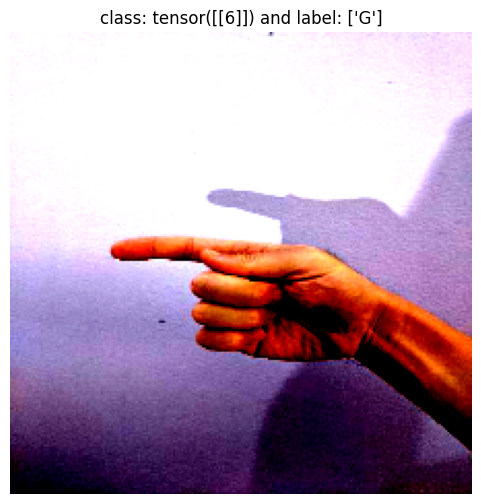

In [35]:
x,y = next(iter(test_dataloader))
print(f'image shape : {x.shape}')
print(f'image tensor - min: {x.min():.3f}, max: {x.max():.3f}')

classes = get_classes()
label_indices = y['labels'][0]
class_name = [classes[idx.item()] for idx in label_indices]

plt.figure(figsize=(6,6))
plt.imshow(x[0].permute(1,2,0))
plt.title(f"class: {y['labels']} and label: {class_name}")
plt.axis('off')
plt.show()

In [36]:
logger.test('running inference on test batch')
st = time.time()
result = model(x)
inf_t = (time.time() - st)*1000
print(f"Inference time: {inf_t:.2f} ms")
print(f"Result keys: {result.keys()}")
print(f"Predicted logits shape: {result['pred_logits'].shape}")
print(f"Predicted boxes shape: {result['pred_boxes'].shape}")

[12/15/25 15:42:03] INFO     🧪 running inference on test batch

Inference time: 109.93 ms
Result keys: dict_keys(['pred_logits', 'pred_boxes'])
Predicted logits shape: torch.Size([1, 100, 27])
Predicted boxes shape: torch.Size([1, 100, 4])


In [37]:
probabilities = result['pred_logits'].softmax(-1)[:,:,:-1]
max_probs, max_classes = probabilities.max(-1)

print(f"Probabilities shape: {probabilities.shape}")
print(f"Max probabilities shape: {max_probs.shape}")
print(f"Max classes shape: {max_classes.shape}")
print(f"\nTop 5 predictions (before filtering):")

top5_probs, top5_indices = max_probs[0].topk(5)
for i, (prob, idx) in enumerate(zip(top5_probs,top5_indices)):
    print(f"{i+1}. class: {max_classes[0,idx].item()}, confidence: {prob:.4f}")

Probabilities shape: torch.Size([1, 100, 26])
Max probabilities shape: torch.Size([1, 100])
Max classes shape: torch.Size([1, 100])

Top 5 predictions (before filtering):
1. class: 6, confidence: 0.8722
2. class: 6, confidence: 0.6454
3. class: 6, confidence: 0.5989
4. class: 6, confidence: 0.0854
5. class: 6, confidence: 0.0698


In [38]:
# See ALL 100 predictions (not just top 5)
for i in range(100):
    print(f"Query {i}: class {max_classes[0,i].item()}, confidence {max_probs[0,i]:.4f}")

# See which queries predicted the same class
class_5_queries = (max_classes[0] == 5).nonzero()
print(f"Queries that predicted class 5: {class_5_queries}")

Query 0: class 6, confidence 0.0292
Query 1: class 6, confidence 0.0100
Query 2: class 6, confidence 0.0066
Query 3: class 6, confidence 0.0107
Query 4: class 6, confidence 0.0097
Query 5: class 6, confidence 0.0086
Query 6: class 6, confidence 0.6454
Query 7: class 6, confidence 0.0100
Query 8: class 6, confidence 0.0128
Query 9: class 6, confidence 0.0350
Query 10: class 6, confidence 0.0268
Query 11: class 6, confidence 0.0097
Query 12: class 6, confidence 0.0099
Query 13: class 6, confidence 0.0119
Query 14: class 6, confidence 0.0097
Query 15: class 6, confidence 0.0087
Query 16: class 6, confidence 0.0074
Query 17: class 6, confidence 0.0344
Query 18: class 6, confidence 0.0376
Query 19: class 6, confidence 0.0095
Query 20: class 6, confidence 0.0221
Query 21: class 6, confidence 0.0096
Query 22: class 6, confidence 0.0094
Query 23: class 6, confidence 0.0106
Query 24: class 6, confidence 0.0117
Query 25: class 6, confidence 0.0069
Query 26: class 6, confidence 0.0112
Query 27: c

In [1]:
import torch 
from torch import nn 
query_pos = nn.Parameter(torch.randn(100,256))
query_pos.shape

torch.Size([100, 256])

In [7]:
len(query_pos[0])

256